In [1]:
import random
import datetime
from os import listdir

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from math import radians, degrees, sin, cos, asin, acos, sqrt

from sklearn import metrics

import seaborn as sns

import itertools


## Read in data

In [3]:
path = 'cabspottingdata/'

files = [file_name for file_name in listdir(path) if file_name.endswith('.txt')]
print(f'All files are {len(files)}')

All files are 537


In [4]:
df=pd.DataFrame()
for file in files:
    taxi_df=pd.read_csv(path+file, sep=' ', header=None)
    taxi_df.columns= ['latitude', 'longitude', 'occupancy', 'timestamp']
    taxi_df["taxi"]=file.split(".txt")[0]
    df=df.append(taxi_df)

In [6]:
df.shape

(11220058, 5)

Check if Taxi id number equal to file number

In [7]:
len(set(df["taxi"]))==len(files)

True

In [114]:
df.head()

,latitude,longitude,occupancy,timestamp,taxi
0,37.75153,-122.39447,0,1211033530,new_abboip
1,37.75149,-122.39447,0,1211033614,new_abboip
2,37.75149,-122.39447,0,1211033674,new_abboip
3,37.75149,-122.39446,0,1211033735,new_abboip
4,37.75144,-122.39449,0,1211035303,new_abboip


## Preprocess

In [8]:
df=df.sort_values(by=['taxi','timestamp'])

In [9]:
for metric in ["latitude","longitude","timestamp","occupancy"]:
    df["pre_"+metric]=df.groupby("taxi")[metric].shift(1)

In [130]:
df.head()

,latitude,longitude,occupancy,timestamp,taxi,pre_latitude,pre_longitude,pre_timestamp,pre_occupancy
0,37.75153,-122.39447,0,1211033530,new_abboip,NaN,NaN,NaN,NaN
1,37.75149,-122.39447,0,1211033614,new_abboip,37.75153,-122.39447,1.211034e+09,0.0
2,37.75149,-122.39447,0,1211033674,new_abboip,37.75149,-122.39447,1.211034e+09,0.0
3,37.75149,-122.39446,0,1211033735,new_abboip,37.75149,-122.39447,1.211034e+09,0.0
4,37.75144,-122.39449,0,1211035303,new_abboip,37.75149,-122.39446,1.211034e+09,0.0


In [10]:
df.isnull().sum()

latitude           0
longitude          0
occupancy          0
timestamp          0
taxi               0
pre_latitude     537
pre_longitude    537
pre_timestamp    537
pre_occupancy    537
dtype: int64

Calculate the distance of consectutive movement in the records

In [31]:
# Refer to https://www.geeksforgeeks.org/program-distance-two-points-earth/##

def distance(lat1, lat2, lon1, lon2):

        lon1 = radians(lon1)
        lon2 = radians(lon2)
        lat1 = radians(lat1)
        lat2 = radians(lat2)
        
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    
        c = 2 * asin(sqrt(a))
        
        # Radius of earth in kilometers. Use 3956 for miles
        #r = 6371
        r=3956
        
        # calculate the result
        return(c * r)


In [12]:
df["distance"]=df.apply(lambda row:distance(row["latitude"],row["pre_latitude"],row["longitude"],row["pre_longitude"]),axis=1)

In [13]:
df["duration"]=df["timestamp"]-df["pre_timestamp"]
df["state_change"]=df["occupancy"]-df["pre_occupancy"]
df["latitude_change"]=df["latitude"]-df["pre_latitude"]
df["longitude_change"]=df["longitude"]-df["pre_longitude"]

In [17]:
df=df.drop(["pre_timestamp","pre_occupancy","pre_latitude","pre_longitude"],axis=1)

In [18]:
df.head()

,latitude,longitude,occupancy,timestamp,taxi,distance,duration,state_change,latitude_change,longitude_change
0,37.75153,-122.39447,0,1211033530,new_abboip,NaN,NaN,NaN,NaN,NaN
1,37.75149,-122.39447,0,1211033614,new_abboip,0.002762,84.0,0.0,-0.00004,0.00000
2,37.75149,-122.39447,0,1211033674,new_abboip,0.000000,60.0,0.0,0.00000,0.00000
3,37.75149,-122.39446,0,1211033735,new_abboip,0.000546,61.0,0.0,0.00000,0.00001
4,37.75144,-122.39449,0,1211035303,new_abboip,0.003821,1568.0,0.0,-0.00005,-0.00003


In [19]:
df.isnull().sum()

latitude              0
longitude             0
occupancy             0
timestamp             0
taxi                  0
distance            537
duration            537
state_change        537
latitude_change     537
longitude_change    537
dtype: int64

In [20]:
df=df.fillna(0)

In [21]:
df.to_csv("master_data.csv",index=False)

In [17]:
# df=pd.read_csv("master_data.csv")
# df=df.sort_values(by=['taxi','timestamp'])

## EDA

In [24]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df.describe()

,latitude,longitude,occupancy,timestamp,distance,duration,state_change,latitude_change,longitude_change
count,11220058.00000,11220058.00000,11220058.00000,11220058.00000,11220058.00000,11220058.00000,11220058.00000,11220058.00000,11220058.00000
mean,37.76360,-122.41243,0.44722,1212036378.24358,0.25589,91.15745,0.00000,-0.00000,0.00000
std,0.05386,0.03578,0.49721,588568.31508,1.40452,1567.07180,0.28756,0.01941,0.00898
min,32.86970,-127.08143,0.00000,1211018404.00000,0.00000,0.00000,-1.00000,-12.69148,-6.84999
25%,37.75513,-122.42525,0.00000,1211522838.00000,0.02014,52.00000,0.00000,-0.00079,-0.00111
50%,37.78106,-122.41106,0.00000,1212043209.00000,0.14508,60.00000,0.00000,0.00000,0.00000
75%,37.79045,-122.40027,1.00000,1212548807.00000,0.28575,62.00000,0.00000,0.00086,0.00112
max,50.30546,-115.56218,1.00000,1213089934.00000,876.50302,1488682.00000,1.00000,12.67098,6.84992


Check the movement range of each step in the records. On average, each movement has change in latitude and/or longitude of 0.0025. Will refer to this typical movement scale later on.

In [51]:
latitude_change_abs_mean=abs(df["latitude_change"]).mean()
print(latitude_change_abs_mean)

0.002592008561809572


In [52]:
longitude_change_abs_mean=abs(df["longitude_change"]).mean()
print(longitude_change_abs_mean)

0.00248415719063128


## Q1: Co2 emission reduction potential

To calculate the potential for a yearly reduction in CO2 emissions, caused by the taxi cabs roaming without passengers. In your calculation, please assume that the taxicab fleet is changing at the rate of 15% per month (from combustion engine-powered vehicles to electric vehicles). Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile.

calcuate the total roaming distance without a passenger for the month in data

In [748]:
non_occupancy_distance=sum(df.loc[df["occupancy"]==0]["distance"])

In [750]:
print(non_occupancy_distance)

1263482.9152560702


Reduction rate of driving distance without passenger in one year, along with 15% per month's changing rate from engine-powred vehicles to electric vehicles. 

In [752]:
reduction_rate=1-(1-0.85**12)/(1-0.85)/12

In [753]:
print(reduction_rate)

0.5234676428534291


Annual reduction potential in CO2 emissions

In [755]:
reduction_potential=non_occupancy_distance*404*12*reduction_rate

In [756]:
print(reduction_potential)

3206430468.8112993


## Q2: Predict the next place a passenger will hail a cab

This task will be finised in two steps. 

First step: contruct a classification model to predict that given a next destination, if the un-loaded taxi will pick up a passenger.

Second step: perform simultion on possible next desitnations of an un-loaded taxi, and make preditions by using the ML model obtained in step 1. Based on the predictions on simulated destinations, ### recommand taxi the next destination with higher possibility to pick up a passenger 

### Classification model buiding 

Get the very initial drop off time and very last pick up time of each taxi

In [130]:
first_drop_off=df.loc[df["state_change"]==-1].groupby("taxi")["timestamp"].min().reset_index().rename(columns={"timestamp":"first_drop_off_timestamp"})
last_pick_up=df.loc[df["state_change"]==1].groupby("taxi")["timestamp"].max().reset_index().rename(columns={"timestamp":"last_pick_up_timestamp"})

In [131]:
df=df.merge(first_drop_off,on="taxi",how="left").merge(last_pick_up,on="taxi",how="left")

Keep complete sessions of each taxi. Complete session means a session starts from a passenger drop off to another passenger pick up

In [132]:
truncated_df=df.loc[(df["timestamp"]>=df["first_drop_off_timestamp"]) & (df["timestamp"]<=df["last_pick_up_timestamp"])]

Construct all "drop-off -> pick-up" sessions

In [133]:
truncated_df=truncated_df.loc[~((truncated_df["occupancy"]==1) & (truncated_df["state_change"]==0))]

In [134]:
truncated_df.loc[truncated_df["state_change"]==-1,"duration"]=0
truncated_df.loc[truncated_df["state_change"]==-1,"distance"]=0

Construct drop-off->pick-up sessions for each taxies and assign session id

In [135]:
pick_up_df=truncated_df.loc[truncated_df["state_change"]==1][["taxi","timestamp"]].sort_values(by=["taxi","timestamp"])
pick_up_df["session_id"]=pick_up_df.reset_index().index

truncated_df=truncated_df.merge(pick_up_df,on=["taxi","timestamp"],how="left")
truncated_df["session_id"]=truncated_df["session_id"].bfill()
truncated_df["session_id"]=truncated_df["session_id"].astype(int)

Get the accumulated duration and distance since the drop off in each session

In [137]:
truncated_df["duration_cumsum"]=truncated_df.groupby(["session_id"])["duration"].cumsum()
truncated_df["distance_cumsum"]=truncated_df.groupby(["session_id"])["distance"].cumsum()

Get the total duration and total roaming distance for 95% of "drop-off -> pick-up" sessions. The portion over 95% will be considered as outlier and I will remove them

In [138]:
duration_threshold=np.percentile([i for i in truncated_df.loc[truncated_df["state_change"]==1]["duration_cumsum"]], 95)
print(duration_threshold)

5183.0


In [139]:
distance_threshold=np.percentile([i for i in truncated_df.loc[truncated_df["state_change"]==1]["distance_cumsum"]], 95)
print(distance_threshold)

13.385964233103099


Check the distribution of session time (in unit of second) and session length (in unit of miles)

<AxesSubplot:>

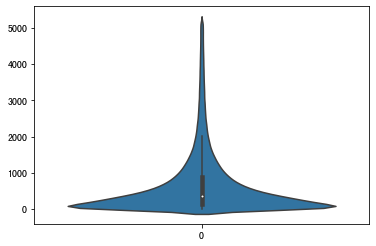

In [16]:
sns.violinplot([i for i in truncated_df.loc[truncated_df["state_change"]==1]["duration_cumsum"] if i<=duration_threshold])

<AxesSubplot:>

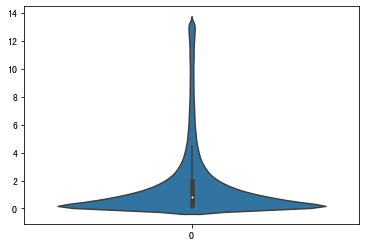

In [17]:
sns.violinplot([i for i in truncated_df.loc[truncated_df["state_change"]==1]["distance_cumsum"] if i<=distance_threshold])

Truncate sessions by the above threshold values

In [140]:
truncated_df=truncated_df.loc[(truncated_df["duration_cumsum"]<=duration_threshold) & (truncated_df["distance_cumsum"]<=distance_threshold)]

In [141]:
truncated_df.shape

(5551718, 15)

In [20]:
truncated_df.loc[truncated_df["state_change"]==1][["duration_cumsum"]].describe()

,duration_cumsum
count,426508.000000
mean,639.020466
std,816.146042
min,1.000000
25%,130.000000
50%,352.000000
75%,813.000000
max,5183.000000


In [142]:
truncated_df.head()

,latitude,longitude,occupancy,timestamp,taxi,distance,duration,state_change,latitude_change,longitude_change,first_drop_off_timestamp,last_pick_up_timestamp,session_id,duration_cumsum,distance_cumsum
0,37.75580,-122.41441,0,1211036160,new_abboip,0.000000,0.0,-1.0,0.00028,-0.00003,1211036160,1213083415,0,0.0,0.000000
1,37.76172,-122.41496,0,1211036230,new_abboip,0.409849,70.0,0.0,0.00592,-0.00055,1211036160,1213083415,0,70.0,0.409849
2,37.76523,-122.41529,0,1211036280,new_abboip,0.243017,50.0,0.0,0.00351,-0.00033,1211036160,1213083415,0,120.0,0.652866
3,37.76511,-122.41935,0,1211036344,new_abboip,0.221758,64.0,0.0,-0.00012,-0.00406,1211036160,1213083415,0,184.0,0.874624
4,37.76342,-122.41992,0,1211036401,new_abboip,0.120763,57.0,0.0,-0.00169,-0.00057,1211036160,1213083415,0,241.0,0.995387


In [143]:
#truncated_df.to_csv("truncated_df.csv",index=False)

In [2]:
#truncated_df=pd.read_csv("truncated_df.csv")


The truncated_df data is too big for the following processing. Due to the limited time on this assignment, will perform data sampling.

Sample 1000 sessions from all 463511 sessions. The sampled sessions may come from different taxies. Would like to increase sample size for a better model performance if there is capacity.

In [113]:
session_list=list(truncated_df.session_id.unique())

In [206]:
len(session_list)

463511

In [207]:
random.seed(0)
sampled_session=random.sample(session_list,20000)

In [274]:
old_master_df_file_name="master_df_20000.csv"
new_master_df_file_name="master_df_40000.csv"

In [275]:
master_df_last=pd.read_csv(old_master_df_file_name)


In [276]:
len(set(master_df_last.session_id))

19985

In [277]:
sampled_session=random.sample(set(session_list)-set(master_df_last.session_id),20000)

In [278]:
len(sampled_session)

20000

In [279]:
sampled_truncated_df=truncated_df.loc[truncated_df["session_id"].isin(sampled_session)]

Start generating additional features

Get weekday, hour, minute from unix timestamp

In [280]:
import multiprocessing as mp

import datetime

def generate_weekday(timestamp):
    return datetime.datetime.fromtimestamp(timestamp).weekday()

def generate_hour(timestamp):
    return datetime.datetime.fromtimestamp(timestamp).hour

def generate_minute(timestamp):
    return datetime.datetime.fromtimestamp(timestamp).minute

with mp.Pool(mp.cpu_count()) as pool:
    sampled_truncated_df['weekday'] = pool.map(generate_weekday, sampled_truncated_df['timestamp'])
    sampled_truncated_df['hour'] = pool.map(generate_hour, sampled_truncated_df['timestamp'])
    sampled_truncated_df['minute'] = pool.map(generate_minute, sampled_truncated_df['timestamp'])

/home/vastar/anaconda3/envs/ktrain/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/vastar/anaconda3/envs/ktrain/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/vastar/anaconda3/envs/ktrain/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Get speed property

In [281]:
sampled_truncated_df["speed"]=sampled_truncated_df["distance"]/sampled_truncated_df["duration"]
sampled_truncated_df=sampled_truncated_df.fillna(0)

/home/vastar/anaconda3/envs/ktrain/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [282]:
sampled_truncated_df["index"]=np.arange(sampled_truncated_df.shape[0])
sampled_truncated_df=sampled_truncated_df.reset_index()

Construct features based on road information. I will look at 
1) Other taxi number in the nearby region of the taxi under track in the past given time period (1 minute)
2) Occupancy ratio of all taxies in 1)
3) All taxi numbers in the past given period (1 minute)
4) Occupancy ratio of all taxies in 3)

These collective information will be proved to be very important for the prediction model

In [283]:
delta_latitude=0.0025*4
delta_longitude=0.0025*4
delta_timestamp=60*1

def get_road_info(i):
    latitude,longitude,timestamp=sampled_truncated_df.loc[i,["latitude","longitude","timestamp"]]

    all_df=df.loc[(df["timestamp"]>=(timestamp-delta_timestamp)) & (df["timestamp"]<=timestamp)]
    taxi_cnt=len(set(all_df["taxi"]))
    taxi_occupancy_ratio=len(set(all_df.loc[all_df["occupancy"]==1]["taxi"]))/taxi_cnt

    surround_df=all_df.loc[(df["longitude"]<=(longitude+delta_longitude)) & (df["longitude"]>=(longitude-delta_longitude)) \
        & (df["latitude"]<=(latitude+delta_latitude)) & (df["latitude"]>=(latitude-delta_latitude)) \
        ]

    surround_taxi_cnt=len(set(surround_df["taxi"]))
    surround_taxi_occupancy_ratio=len(set(surround_df.loc[surround_df["occupancy"]==1]["taxi"]))/surround_taxi_cnt

    return i,surround_taxi_cnt,surround_taxi_occupancy_ratio,taxi_cnt,taxi_occupancy_ratio

In [284]:

with mp.Pool(mp.cpu_count()) as pool:
    road_info=pool.map(get_road_info, range(sampled_truncated_df.shape[0]))


In [285]:
road_info_df=pd.DataFrame(road_info)
road_info_df.columns=["index","surround_taxi_cnt","surround_taxi_occupancy_ratio","taxi_cnt","taxi_occupancy_ratio"]

In [286]:
road_info_df.head()

,index,surround_taxi_cnt,surround_taxi_occupancy_ratio,taxi_cnt,taxi_occupancy_ratio
0,0,4,0.500000,287,0.512195
1,1,3,0.333333,286,0.506993
2,2,3,0.666667,280,0.528571
3,3,3,0.666667,287,0.526132
4,4,7,0.857143,288,0.517361


In [287]:
sampled_truncated_df=sampled_truncated_df.merge(road_info_df,on="index",how="left")

In [288]:
sampled_truncated_df.head()

,level_0,latitude,longitude,occupancy,timestamp,taxi,distance,duration,state_change,latitude_change,...,distance_cumsum,weekday,hour,minute,speed,index,surround_taxi_cnt,surround_taxi_occupancy_ratio,taxi_cnt,taxi_occupancy_ratio
0,638,37.75288,-122.44283,0,1211155992,new_abboip,0.000000,0.0,-1.0,-0.00012,...,0.000000,0,9,13,0.000000,0,4,0.500000,287,0.512195
1,639,37.75273,-122.44291,0,1211156051,new_abboip,0.011240,59.0,0.0,-0.00015,...,0.011240,0,9,14,0.000191,1,3,0.333333,286,0.506993
2,640,37.75613,-122.44099,0,1211156111,new_abboip,0.257090,60.0,0.0,0.00340,...,0.268330,0,9,15,0.004285,2,3,0.666667,280,0.528571
3,641,37.75961,-122.44475,0,1211156173,new_abboip,0.316007,62.0,0.0,0.00348,...,0.584337,0,9,16,0.005097,3,3,0.666667,287,0.526132
4,642,37.76163,-122.43855,0,1211156232,new_abboip,0.366043,59.0,0.0,0.00202,...,0.950379,0,9,17,0.006204,4,7,0.857143,288,0.517361


Also get the direct distance from the very beginning of each session

In [289]:
session_start_point=sampled_truncated_df.loc[sampled_truncated_df["state_change"]==-1][["session_id","latitude","longitude"]]
session_start_point.columns=["session_id","start_latitude","start_longitude"]
sampled_truncated_df=sampled_truncated_df.merge(session_start_point,on="session_id",how="left")
sampled_truncated_df["direct_distance"]=sampled_truncated_df.apply(lambda row:distance(row["latitude"],row["start_latitude"],row["longitude"],row["start_longitude"]),axis=1)

In [290]:
sampled_truncated_df.head(60)

,level_0,latitude,longitude,occupancy,timestamp,taxi,distance,duration,state_change,latitude_change,...,minute,speed,index,surround_taxi_cnt,surround_taxi_occupancy_ratio,taxi_cnt,taxi_occupancy_ratio,start_latitude,start_longitude,direct_distance
0,638,37.75288,-122.44283,0,1211155992,new_abboip,0.000000,0.0,-1.0,-0.00012,...,13,0.000000,0,4,0.500000,287,0.512195,37.75288,-122.44283,0.000000
1,639,37.75273,-122.44291,0,1211156051,new_abboip,0.011240,59.0,0.0,-0.00015,...,14,0.000191,1,3,0.333333,286,0.506993,37.75288,-122.44283,0.011240
2,640,37.75613,-122.44099,0,1211156111,new_abboip,0.257090,60.0,0.0,0.00340,...,15,0.004285,2,3,0.666667,280,0.528571,37.75288,-122.44283,0.245852
3,641,37.75961,-122.44475,0,1211156173,new_abboip,0.316007,62.0,0.0,0.00348,...,16,0.005097,3,3,0.666667,287,0.526132,37.75288,-122.44283,0.476348
4,642,37.76163,-122.43855,0,1211156232,new_abboip,0.366043,59.0,0.0,0.00202,...,17,0.006204,4,7,0.857143,288,0.517361,37.75288,-122.44283,0.647748
5,643,37.76235,-122.43568,0,1211156294,new_abboip,0.164356,62.0,0.0,0.00072,...,18,0.002651,5,9,0.666667,284,0.535211,37.75288,-122.44283,0.761490
6,644,37.76226,-122.43523,0,1211156362,new_abboip,0.025337,68.0,0.0,-0.00009,...,19,0.000373,6,10,0.500000,293,0.549488,37.75288,-122.44283,0.769128
7,645,37.76181,-122.43518,1,1211156364,new_abboip,0.031190,2.0,1.0,-0.00045,...,19,0.015595,7,11,0.636364,290,0.558621,37.75288,-122.44283,0.744682
8,1241,37.77127,-122.42254,0,1211263116,new_abboip,0.000000,0.0,-1.0,-0.00040,...,58,0.000000,8,37,0.378378,312,0.397436,37.77127,-122.42254,0.000000
9,1242,37.76850,-122.42232,0,1211263177,new_abboip,0.191632,61.0,0.0,-0.00277,...,59,0.003142,9,36,0.361111,315,0.400000,37.77127,-122.42254,0.191632


In [291]:
sampled_truncated_df.columns

Index(['level_0', 'latitude', 'longitude', 'occupancy', 'timestamp', 'taxi',
       'distance', 'duration', 'state_change', 'latitude_change',
       'longitude_change', 'first_drop_off_timestamp',
       'last_pick_up_timestamp', 'session_id', 'duration_cumsum',
       'distance_cumsum', 'weekday', 'hour', 'minute', 'speed', 'index',
       'surround_taxi_cnt', 'surround_taxi_occupancy_ratio', 'taxi_cnt',
       'taxi_occupancy_ratio', 'start_latitude', 'start_longitude',
       'direct_distance'],
      dtype='object')

In [292]:
uncontrollable_features=['surround_taxi_cnt', 'surround_taxi_occupancy_ratio', 'taxi_cnt','taxi_occupancy_ratio','duration_cumsum','distance_cumsum','direct_distance','speed']

controllable_features=['latitude', 'longitude', 'latitude_change','longitude_change', 'weekday', 'hour', 'minute',"timestamp"]

target=["occupancy"]


In [293]:
set(sampled_truncated_df.columns)-set(uncontrollable_features)-set(controllable_features)-set(target)

{'distance',
 'duration',
 'first_drop_off_timestamp',
 'index',
 'last_pick_up_timestamp',
 'level_0',
 'session_id',
 'start_latitude',
 'start_longitude',
 'state_change',
 'taxi'}

By shifting the following features, get the values in previous movement steps as new features (historical features)

In [294]:
for col in uncontrollable_features:
    for shift in [1,2,3]:
        sampled_truncated_df[f"shift_{shift}_"+col]=sampled_truncated_df.groupby("session_id")[col].shift(shift)
        sampled_truncated_df[f"shift_{shift}_"+col]=sampled_truncated_df[f"shift_{shift}_"+col].bfill()


Next movement related feature. These features a somehow controllable by drivers - next destination, time to reach next destination. They will also be features for our simulation later.

Prediction target variable will be "next_occupancy". We want to know, with current road information and past journey information, if the taxi reaches some next destination, a passenger will be picked up or not

In [295]:
for col in controllable_features+target:
    sampled_truncated_df["next_"+col]=sampled_truncated_df.groupby("session_id")[col].shift(-1)
    

We want to know the "direction" of each movement, as the magnitude is already covered by other features

In [296]:
sampled_truncated_df["latitude_change"]=np.sign(sampled_truncated_df["latitude_change"])
sampled_truncated_df["longitude_change"]=np.sign(sampled_truncated_df["longitude_change"])
sampled_truncated_df["next_latitude_change"]=np.sign(sampled_truncated_df["next_latitude_change"])
sampled_truncated_df["next_longitude_change"]=np.sign(sampled_truncated_df["next_longitude_change"])

Further encode time related features as they are cyclic

In [297]:
for feature in ['weekday', 'next_weekday']:
    sampled_truncated_df[feature+"_cyclical"]=sampled_truncated_df.apply(lambda row:sin(row[feature]/7*2*np.pi),axis=1)

for feature in ['hour', 'next_hour']:
    sampled_truncated_df[feature+"_cyclical"]=sampled_truncated_df.apply(lambda row:sin(row[feature]/24*2*np.pi),axis=1)

for feature in ['minute', 'next_minute']:
    sampled_truncated_df[feature+"_cyclical"]=sampled_truncated_df.apply(lambda row:sin(row[feature]/60*2*np.pi),axis=1)

Collect necessary columns

In [298]:
select_col=["session_id","taxi"]+uncontrollable_features+controllable_features+[i for i in sampled_truncated_df.columns if ("shift_" in i or "next_" in i)]

In [299]:
select_col

['session_id',
 'taxi',
 'surround_taxi_cnt',
 'surround_taxi_occupancy_ratio',
 'taxi_cnt',
 'taxi_occupancy_ratio',
 'duration_cumsum',
 'distance_cumsum',
 'direct_distance',
 'speed',
 'latitude',
 'longitude',
 'latitude_change',
 'longitude_change',
 'weekday',
 'hour',
 'minute',
 'timestamp',
 'shift_1_surround_taxi_cnt',
 'shift_2_surround_taxi_cnt',
 'shift_3_surround_taxi_cnt',
 'shift_1_surround_taxi_occupancy_ratio',
 'shift_2_surround_taxi_occupancy_ratio',
 'shift_3_surround_taxi_occupancy_ratio',
 'shift_1_taxi_cnt',
 'shift_2_taxi_cnt',
 'shift_3_taxi_cnt',
 'shift_1_taxi_occupancy_ratio',
 'shift_2_taxi_occupancy_ratio',
 'shift_3_taxi_occupancy_ratio',
 'shift_1_duration_cumsum',
 'shift_2_duration_cumsum',
 'shift_3_duration_cumsum',
 'shift_1_distance_cumsum',
 'shift_2_distance_cumsum',
 'shift_3_distance_cumsum',
 'shift_1_direct_distance',
 'shift_2_direct_distance',
 'shift_3_direct_distance',
 'shift_1_speed',
 'shift_2_speed',
 'shift_3_speed',
 'next_latitud

Prepare master table for machine learning model building

In [300]:
master_df=sampled_truncated_df[select_col]
master_df=master_df.dropna()

In [301]:
master_df.columns

Index(['session_id', 'taxi', 'surround_taxi_cnt',
       'surround_taxi_occupancy_ratio', 'taxi_cnt', 'taxi_occupancy_ratio',
       'duration_cumsum', 'distance_cumsum', 'direct_distance', 'speed',
       'latitude', 'longitude', 'latitude_change', 'longitude_change',
       'weekday', 'hour', 'minute', 'timestamp', 'shift_1_surround_taxi_cnt',
       'shift_2_surround_taxi_cnt', 'shift_3_surround_taxi_cnt',
       'shift_1_surround_taxi_occupancy_ratio',
       'shift_2_surround_taxi_occupancy_ratio',
       'shift_3_surround_taxi_occupancy_ratio', 'shift_1_taxi_cnt',
       'shift_2_taxi_cnt', 'shift_3_taxi_cnt', 'shift_1_taxi_occupancy_ratio',
       'shift_2_taxi_occupancy_ratio', 'shift_3_taxi_occupancy_ratio',
       'shift_1_duration_cumsum', 'shift_2_duration_cumsum',
       'shift_3_duration_cumsum', 'shift_1_distance_cumsum',
       'shift_2_distance_cumsum', 'shift_3_distance_cumsum',
       'shift_1_direct_distance', 'shift_2_direct_distance',
       'shift_3_direct_distan

In [302]:
master_df=master_df.append(master_df_last)

In [303]:
master_df.to_csv(new_master_df_file_name,index=False)

In [304]:

master_sessions=list(master_df.session_id.unique())

In [305]:
len(master_sessions)

39970

I will split train and valid data by session id. In the same session (a drop-off->pick-up journey), the data is quite similar. So if train and valid data belong to same sessions, there will be data leakagy which will result in over-evaluation on models.

In [306]:
random.seed(0)
train_sessions=random.sample(master_sessions,int(len(master_sessions)*0.8))
valid_sessions=list(set(master_sessions)-set(train_sessions))

train_df=master_df.loc[master_df["session_id"].isin(train_sessions)]
valid_df=master_df.loc[master_df["session_id"].isin(valid_sessions)]

In [307]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 9 hours 55 mins
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_vastar_9rjm5f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.005 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [308]:
from h2o.automl import H2OAutoML


train = h2o.H2OFrame(train_df)
valid = h2o.H2OFrame(valid_df)

y="next_occupancy"

x=train.columns

# remove unwanted columns from feature list
for col in ["taxi","next_occupancy","session_id","timestamp","next_timestamp","weekday","hour","minute","next_weekday","next_hour","next_minute"]:
    x.remove(col)

train[y]=train[y].asfactor()
valid[y]=valid[y].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [309]:
aml = H2OAutoML(max_models=30, seed=1, include_algos=["GBM","XGBoost","DRF"],sort_metric="AUCPR",nfolds=3)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_47_20221218_100546_model_3


Model Summary: 
    number_of_trees
--  -----------------
    166

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04577941044828882
RMSE: 0.2139612358542753
LogLoss: 0.16242990522774212
Mean Per-Class Error: 0.23580026101803206
AUC: 0.9297161101618935
AUCPR: 0.6835834922928151
Gini: 0.859432220323787

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23009259441938368
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      312946  8525   0.0265   (8525.0/321471.0)
1      13113   16349  0.4451   (13113.0/29462.0)
Total  326059  24874  0.0617   (21638.0/350933.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.230093     0.601774  184
max f2                       0.129117     0.656896  249
max f0point5                 0.367616     0.692216  131
max accuracy                 0.35156      0.943559  136
max precision                0.999851     0.998342  0
max recall                   0.00169321   1         395
max specificity              0.999851     0.999988  0
max absolute_mcc             0.258376     0.573609  171
max min_per_class_accuracy   0.104961     0.843799  270
max mean_per_class_accuracy  0.097298     0.844573  277
max tns                      0.999851     321467    0
max fns                      0.999851     27054     0
max fps                      0.000204846  321471    399
max tps                      0.00169321   29462     395
max tnr                      0.999851     0.999988  0
max fnr                      0.999851     0.918268  0
max fpr                      0.000204846  1         399
max tpr                      0.00169321   1         395

Gains/Lift Table: Avg response rate:  8.40 %, avg score:  8.40 %
group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -----------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100019                   0.994899           11.8808      11.8808            0.997436         0.999208     0.997436                    0.999208            0.118831        0.118831                   1088.08   1088.08            0.118803
2        0.020001                    0.707961           11.779       11.8299            0.988886         0.903574     0.993161                    0.951398            0.117779        0.23661                    1077.9    1082.99            0.236461
3        0.03                        0.453002           9.27383      10.978             0.778569         0.555408     0.921638                    0.819414            0.0927296       0.329339                   827.383   997.797            0.326773
4        0.0400019                   0.350697           7.26221      10.0489            0.609687         0.396051     0.843639                    0.713558            0.0726359       0.401975                   626.221   904.89             0.395147
5        0.050001                    0.294563           5.82839      9.20489            0.489313         0.319969     0.772782                    0.634849            0.0582785       0.460254                   482.839   820.489            0.447852
6        0.100002                    0.181323           3.80483      6.50486            0.319428         0.225885     0.546105                    0.430367            0.190245        0.650499                   280.483   550.486            0.600949
7        0

Evaluate on valid data set

In [310]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

model_cls = aml.get_best_model()
pred_cls=model_cls.predict(valid)
pred_cls=pred_cls.as_data_frame()

extend_valid_df=valid.as_data_frame()
extend_valid_df["predict"]=pred_cls["predict"].values

print(classification_report(extend_valid_df[y],extend_valid_df["predict"]))
print("confusion matrix:")
confusion_matrix(extend_valid_df[y],extend_valid_df["predict"])

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     79929
           1       0.54      0.44      0.49      7394

    accuracy                           0.92     87323
   macro avg       0.75      0.70      0.72     87323
weighted avg       0.91      0.92      0.92     87323

confusion matrix:


array([[77176,  2753],
       [ 4141,  3253]])

The performance is not bad, considering the data imbalance. 

Check shap values

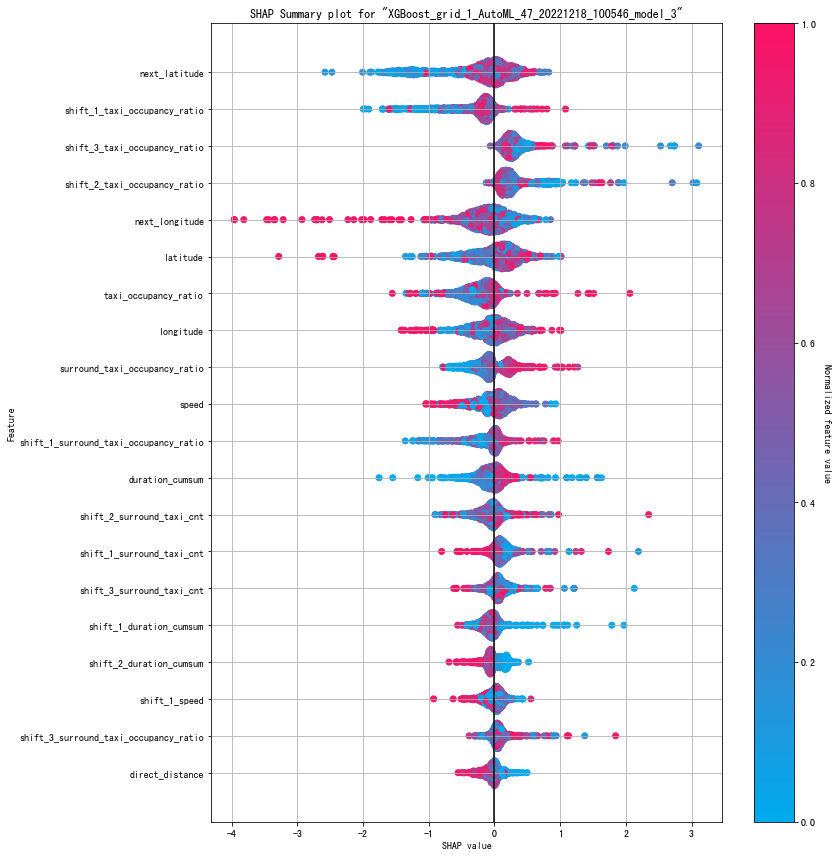

In [311]:
model_cls.shap_summary_plot(valid,  top_n_features = 20)

However, the next destination feature is not on top of the important features. So I will exclude the "current position" related features to promote the "next destination" features. 

In [312]:
for col in ["latitude","longitude"]:
    x.remove(col)

In [313]:
aml = H2OAutoML(max_models=30, seed=1, include_algos=["GBM"],sort_metric="AUCPR",nfolds=3)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_48_20221218_104024


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    148                148                         230882                 0            8            6.10811       1             235           119.426

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05216925872334153
RMSE: 0.2284059078118198
LogLoss: 0.19056134066725097
Mean Per-Class Error: 0.28171898056452677
AUC: 0.8826226104779351
AUCPR: 0.5900190852428991
Gini: 0.7652452209558702

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19563353485806712
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      312840  8631   0.0268   (8631.0/321471.0)
1      15809   13653  0.5366   (15809.0/29462.0)
Total  328649  22284  0.0696   (24440.0/350933.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.195634     0.527693  189
max f2                       0.11881      0.560661  244
max f0point5                 0.29693      0.65334   147
max accuracy                 0.29693      0.93957   147
max precision                0.998932     1         0
max recall                   0.00367067   1         396
max specificity              0.998932     1         0
max absolute_mcc             0.274965     0.518316  155
max min_per_class_accuracy   0.0921768    0.783314  272
max mean_per_class_accuracy  0.0911943    0.784817  273
max tns                      0.998932     321471    0
max fns                      0.998932     29008     0
max fps                      0.001914     321471    399
max tps                      0.00367067   29462     396
max tnr                      0.998932     1         0
max fnr                      0.998932     0.98459   0
max fpr                      0.001914     1         399
max tpr                      0.00367067   1         396

Gains/Lift Table: Avg response rate:  8.40 %, avg score:  8.40 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100019                   0.942789           11.891      11.891             0.998291         0.983927    0.998291                    0.983927            0.118933        0.118933                   1089.1    1089.1             0.118914
2        0.020001                    0.536335           11.4905     11.6908            0.964662         0.760991    0.981479                    0.872475            0.114894        0.233827                   1049.05   1069.08            0.233422
3        0.03                        0.338202           8.2385      10.5401            0.69165          0.418526    0.884878                    0.721173            0.0823773       0.316204                   723.85    954.012            0.312434
4        0.0400019                   0.265088           5.80637     9.35652            0.487464         0.296973    0.785511                    0.615108            0.0580748       0.374279                   480.637   835.652            0.364912
5        0.050001                    0.225578           4.28389     8.34211            0.359647    

Check model performance again. Decayed a little bit but not so significant.

In [314]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

model_cls = aml.get_best_model()
pred_cls=model_cls.predict(valid)
pred_cls=pred_cls.as_data_frame()

extend_valid_df=valid.as_data_frame()
extend_valid_df["predict"]=pred_cls["predict"].values

print(classification_report(extend_valid_df[y],extend_valid_df["predict"]))
print("confusion matrix:")
confusion_matrix(extend_valid_df[y],extend_valid_df["predict"])

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     79929
           1       0.52      0.38      0.44      7394

    accuracy                           0.92     87323
   macro avg       0.73      0.68      0.70     87323
weighted avg       0.91      0.92      0.91     87323

confusion matrix:


array([[77303,  2626],
       [ 4548,  2846]])

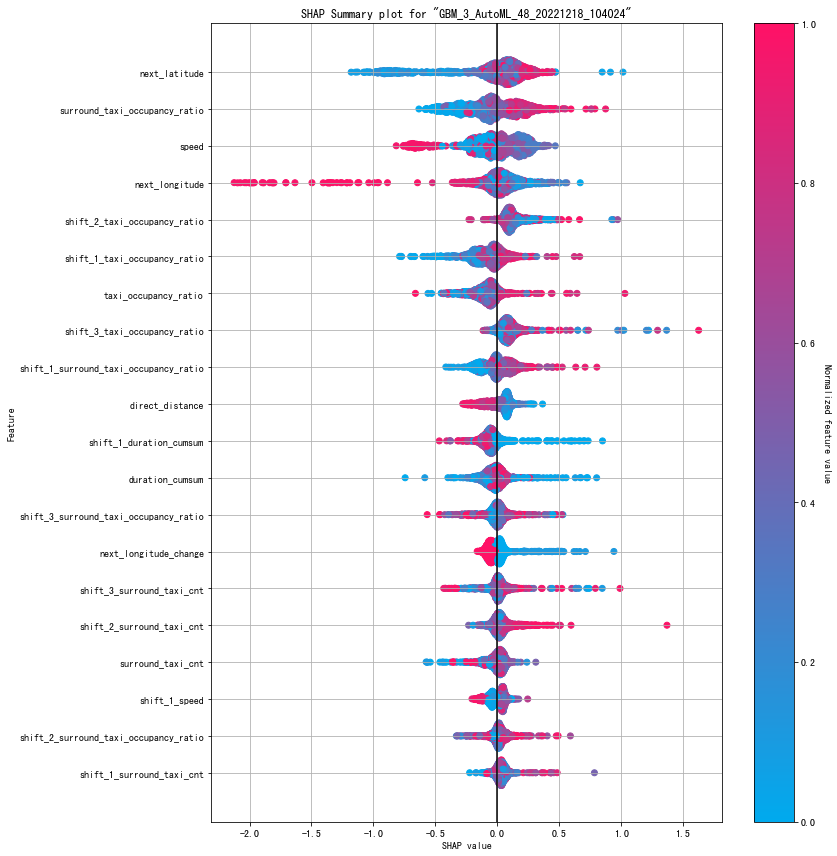

In [315]:
model_cls.shap_summary_plot(valid,  top_n_features = 20)

Based on the above two shap value plots, we can understand
1) Taxi occupancuy rate in the aero surrounding the taxi is important for the taxi to be occupied. This higher ratio means higer deamnd of taxi usage
2) Latitude is important to have a passenger as well. The higher latitude, the higher chance to get a passenger in next destination. This might because the downtown is in the north of San Francisco
3) Speed is also a factor. If speed is too high, means the road is not crowed and hence less passengers. Also, if speed is high, it will be difficult for driver and passenger to see/find each other.

### Next destination recommendation and model verification

I will do a simple simulation based on the obtained model, to show how a recommendation engine can be built. Also by comparing with groud truth data, I will show the effectiveness of the recommendation system.

To save time and make the demonstration easy, I will work on the valid data sets which are "pick-up" cases at the next destination (though our model may predixt wrong with recall 0.36)

Select out the cases correctly predicted by our model and the predicion is a "pick up"

In [316]:
sub_valid_df=extend_valid_df.loc[(extend_valid_df[y]==1)].reset_index()

In [317]:
len(set(sub_valid_df.session_id))

7394

Get some threshold values for later usage, to ensure our simulated cases are making real sense.

In [318]:
max_speed=np.percentile(sampled_truncated_df.loc[sampled_truncated_df["state_change"]!=-1]["speed"],95)

In [319]:
max_distance=np.percentile(sampled_truncated_df.loc[sampled_truncated_df["state_change"]!=-1]["distance"],95)

In [320]:
## randomly select 5 correctly predicted and 5 wrongly predicted cases
sessions=list(sub_valid_df.loc[sub_valid_df["predict"]==1].session_id.unique())[0:10]+list(sub_valid_df.loc[sub_valid_df["predict"]==0].session_id.unique())[0:10]

In [321]:
max_latitude_change=np.percentile(abs(df["latitude_change"]),95)
max_longitude_change=np.percentile(abs(df["longitude_change"]),95)

In [322]:

output_df=pd.DataFrame()

for session in sessions:

    sub_session_df=sub_valid_df.loc[sub_valid_df["session_id"]==session].reset_index()

    # actual pickup places
    sub_session_df["pick_up_latitude"]=sub_session_df["next_latitude"]
    sub_session_df["pick_up_longitude"]=sub_session_df["next_longitude"]

    # For simplicity, here I do not simulate on time and just use the fixed next time stamp (time point to reach next destination) available in data. 
    # For a workable recommandation system, next timestamp can be also simulated 
    timestamp,next_timestamp=sub_session_df.loc[0,["timestamp","next_timestamp"]]

    simulation_duration=next_timestamp-timestamp

    # "next_latitude" or "pick_up_latitude" are not avaivable in actual predict->recommendation application. Here I take them as reference to contrain the simulation space just for the latter better visualization.
    max_latitude_change_tmp=max(max_latitude_change,abs(sub_session_df.loc[0,"next_latitude"]-sub_session_df.loc[0,"latitude"]))*1.1
    max_longitude_change_tmp=max(max_longitude_change,abs(sub_session_df.loc[0,"next_longitude"]-sub_session_df.loc[0,"longitude"]))*1.1

    max_latitude=sub_session_df.loc[0,"latitude"]+max_latitude_change_tmp
    min_latitude=sub_session_df.loc[0,"latitude"]-max_latitude_change_tmp
    max_longitude=sub_session_df.loc[0,"longitude"]+max_longitude_change_tmp
    min_longitude=sub_session_df.loc[0,"longitude"]-max_longitude_change_tmp

    map_df=df.loc[(df["latitude"]<=max_latitude) & (df["latitude"]>=min_latitude) & (df["longitude"]<=max_longitude) & (df["longitude"]>=min_longitude)][["latitude","longitude"]].drop_duplicates().reset_index(drop=True)

    if map_df.shape[0]>20000:
        simulation_df=map_df.sample(n=20000,random_state=1)
    else:
        simulation_df=map_df

    simulation_df.columns=["next_latitude","next_longitude"]

    # attach other feature columns. They are not simulated and they keep the original values
    for col in sub_session_df.columns:
        if col not in ["next_latitude","next_longitude","next_latitude_change","next_longitude_change"]:
            simulation_df[col]=sub_session_df.loc[0,col]

    # rewrite derived features which depend on "next_latitude","next_longitude"
    simulation_df["next_latitude_change"]=np.sign(simulation_df["next_latitude"]-simulation_df["latitude"])
    simulation_df["next_longitude_change"]=np.sign(simulation_df["next_longitude"]-simulation_df["longitude"])


    simulation_df["simulation_distance"]=simulation_df.apply(lambda row:distance(row["next_latitude"],row["latitude"],row["next_longitude"],row["longitude"]),axis=1)

    simulation_df["simulation_speed"]=simulation_df["simulation_distance"]/simulation_duration

    # remove unrealistic cases from simulation space based on consideration of speed and moving distance in a given duration 
    simulation_df=simulation_df.loc[(simulation_df["simulation_speed"]<=max_speed*1.3) & (simulation_df["simulation_distance"]<=max_distance*1.3)]

    if simulation_df.shape[0]>0:

        # apply our model and make predictions
        pred_on_simulation=model_cls.predict(h2o.H2OFrame(simulation_df)).as_data_frame()

        simulation_df["local_p1"]=pred_on_simulation["p1"].values

        simulation_df["local_predict"]=pred_on_simulation["predict"].values

        sub_output_df=simulation_df[["session_id","taxi","timestamp","next_timestamp","next_latitude","next_longitude","latitude","longitude","pick_up_latitude","pick_up_longitude","predict","local_p1","local_predict"]].reset_index(drop=True)

        output_df=output_df.append(sub_output_df)

output_df=output_df.reset_index(drop=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

Check the threshold value of probability for 0/1 classification by the model

In [323]:
output_df.loc[output_df["local_predict"]==1]["local_p1"].min()

0.1956801598004438

In [324]:
output_df.loc[output_df["local_predict"]==0]["local_p1"].max()

0.1956000688144278

In [325]:
output_df["threshold"]=output_df.loc[output_df["local_predict"]==0]["local_p1"].max()

taxi              new_abboip
timestamp         1211581835
next_timestamp    1211581842
predict                    1
threshold             0.1956
Name: 0, dtype: object


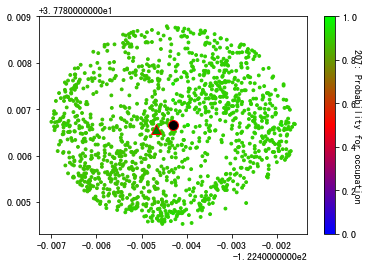

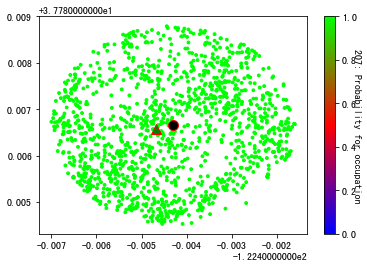

***********
taxi              new_abboip
timestamp         1211597548
next_timestamp    1211597605
predict                    1
threshold             0.1956
Name: 0, dtype: object


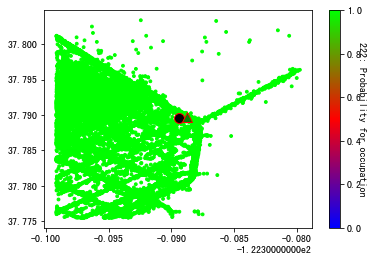

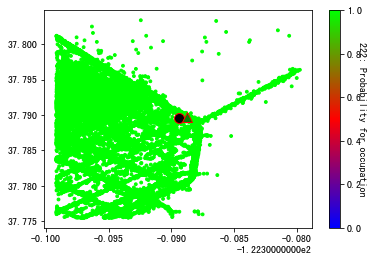

***********
taxi              new_abboip
timestamp         1212176384
next_timestamp    1212177994
predict                    1
threshold             0.1956
Name: 0, dtype: object


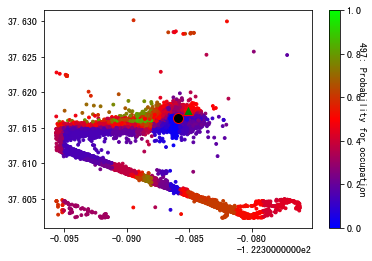

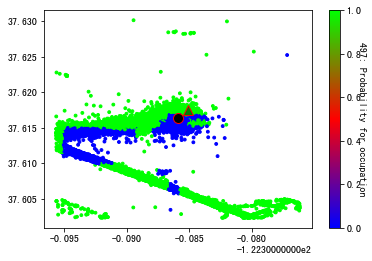

***********
taxi              new_abdremlu
timestamp           1212224978
next_timestamp      1212225018
predict                      1
threshold               0.1956
Name: 0, dtype: object


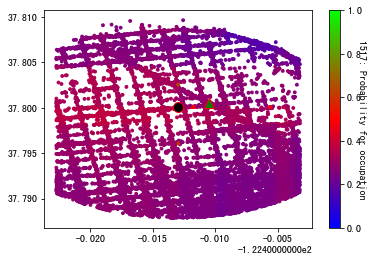

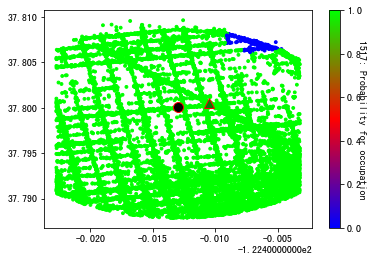

***********
taxi              new_abdremlu
timestamp           1212711856
next_timestamp      1212711905
predict                      1
threshold               0.1956
Name: 0, dtype: object


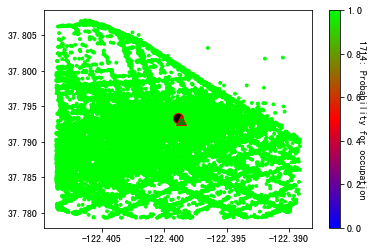

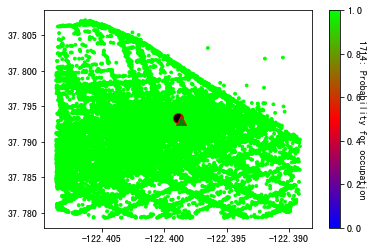

***********
taxi              new_abgibo
timestamp         1211690118
next_timestamp    1211690151
predict                    1
threshold             0.1956
Name: 0, dtype: object


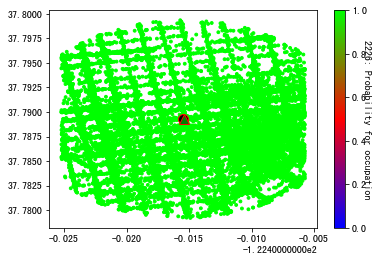

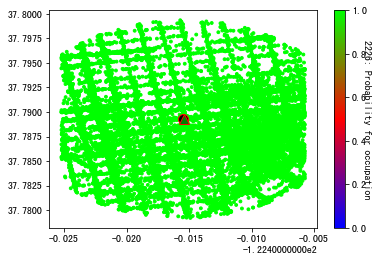

***********
taxi              new_abgibo
timestamp         1211947073
next_timestamp    1211947110
predict                    1
threshold             0.1956
Name: 0, dtype: object


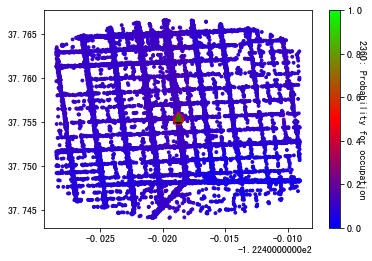

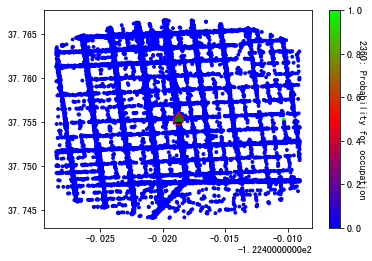

***********
taxi              new_abjoolaw
timestamp           1212978988
next_timestamp      1212978989
predict                      1
threshold               0.1956
Name: 0, dtype: object


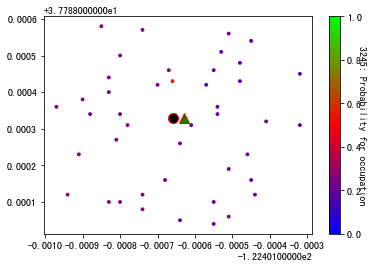

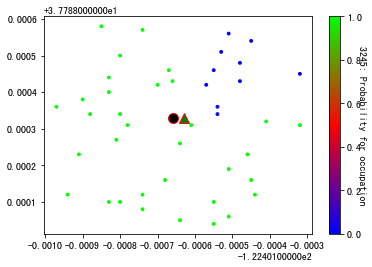

***********
taxi              new_abjoolaw
timestamp           1212992246
next_timestamp      1212992289
predict                      1
threshold               0.1956
Name: 0, dtype: object


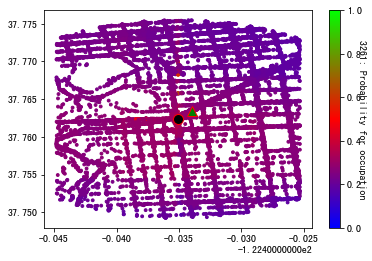

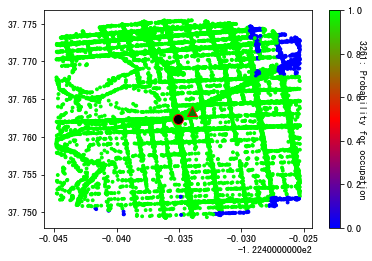

***********
taxi              new_abmuyawm
timestamp           1212274926
next_timestamp      1212274936
predict                      1
threshold               0.1956
Name: 0, dtype: object


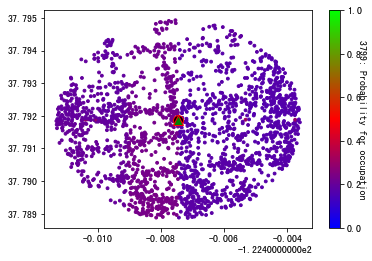

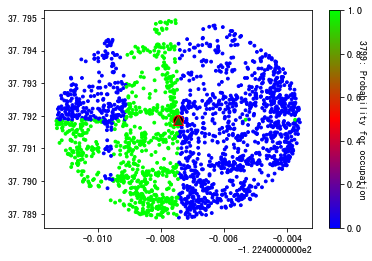

***********
taxi              new_abboip
timestamp         1211280099
next_timestamp    1211280134
predict                    0
threshold             0.1956
Name: 0, dtype: object


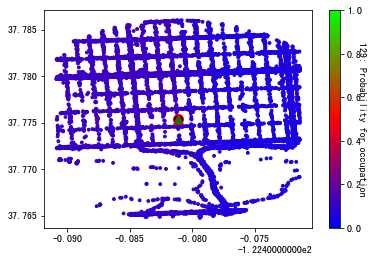

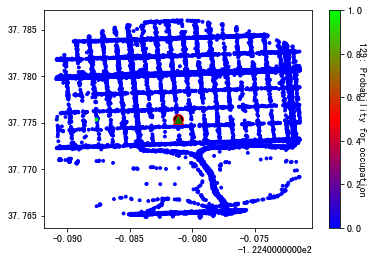

***********
taxi              new_abboip
timestamp         1211468920
next_timestamp    1211468926
predict                    0
threshold             0.1956
Name: 0, dtype: object


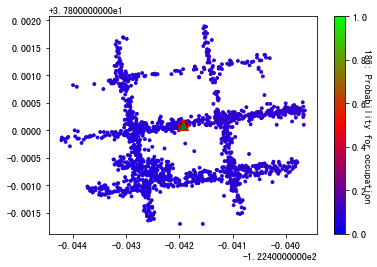

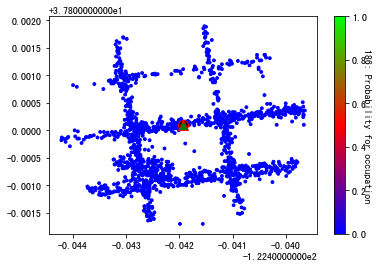

***********
taxi              new_abboip
timestamp         1211766899
next_timestamp    1211766997
predict                    0
threshold             0.1956
Name: 0, dtype: object


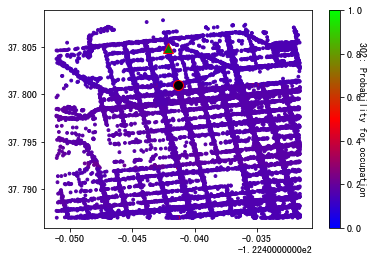

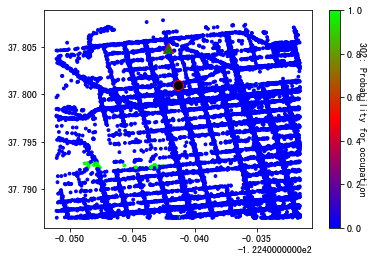

***********
taxi              new_abboip
timestamp         1212442244
next_timestamp    1212442290
predict                    0
threshold             0.1956
Name: 0, dtype: object


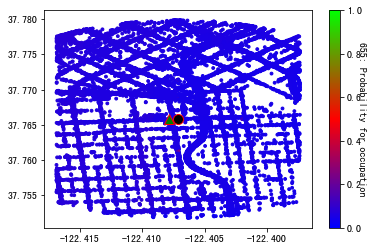

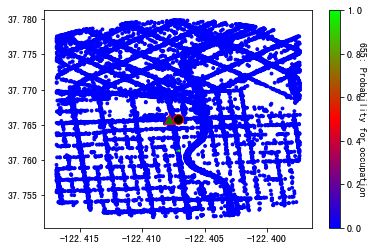

***********
taxi              new_abboip
timestamp         1212511722
next_timestamp    1212511730
predict                    0
threshold             0.1956
Name: 0, dtype: object


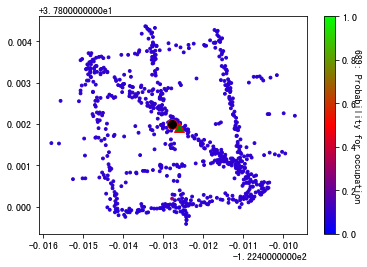

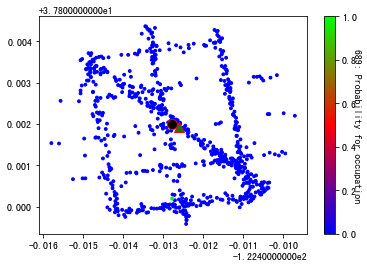

***********
taxi              new_abboip
timestamp         1212638342
next_timestamp    1212638375
predict                    0
threshold             0.1956
Name: 0, dtype: object


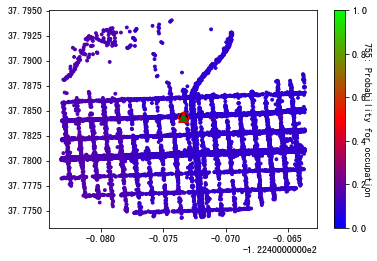

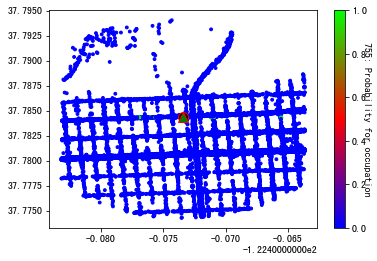

***********
taxi              new_abdremlu
timestamp           1211118862
next_timestamp      1211118915
predict                      0
threshold               0.1956
Name: 0, dtype: object


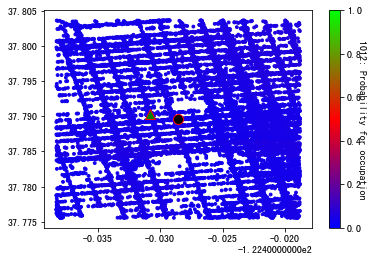

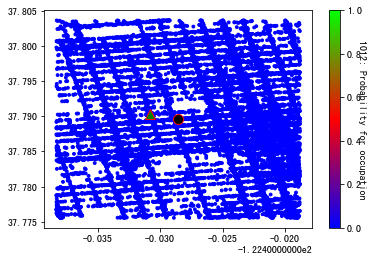

***********
taxi              new_abdremlu
timestamp           1212131193
next_timestamp      1212131195
predict                      0
threshold               0.1956
Name: 0, dtype: object


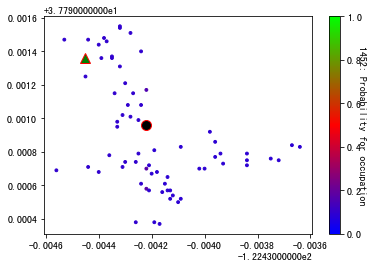

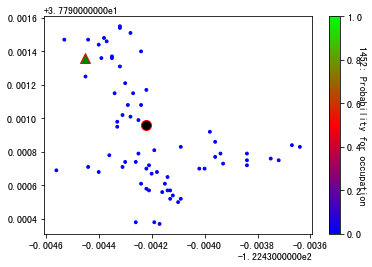

***********
taxi              new_abdremlu
timestamp           1212145977
next_timestamp      1212146048
predict                      0
threshold               0.1956
Name: 0, dtype: object


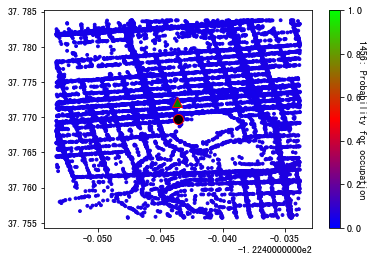

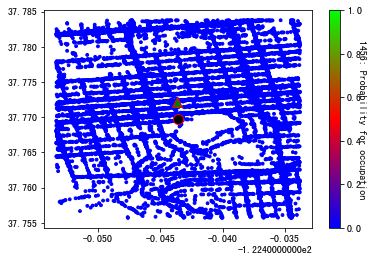

***********
taxi              new_abdremlu
timestamp           1212203957
next_timestamp      1212203996
predict                      0
threshold               0.1956
Name: 0, dtype: object


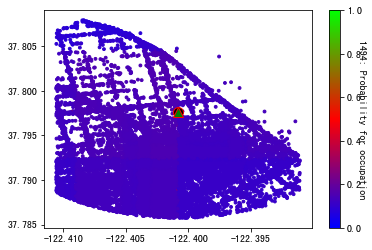

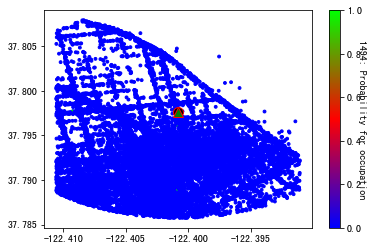

***********


In [330]:
import matplotlib

colormap = plt.cm.brg #or any other colormap
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)


for session in sessions:
    
    tmp=output_df.loc[output_df["session_id"]==session].reset_index()

    print(tmp.loc[0,["taxi","timestamp","next_timestamp","predict","threshold"]])

    ## probability visualization
    plt.scatter(tmp["next_longitude"], tmp["next_latitude"],  c=tmp["local_p1"], s=8,cmap=colormap, alpha=1)

    plt.plot(tmp.loc[0,"longitude"], tmp.loc[0,"latitude"], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="black")

    plt.plot(tmp.loc[0,"pick_up_longitude"], tmp.loc[0,"pick_up_latitude"], marker="^", markersize=10, markeredgecolor="red", markerfacecolor="green")

    plt.colorbar().ax.set_ylabel(f"{session}: Probability for occupation",fontsize=10,rotation=270)
    plt.clim(0,1)

    plt.show()

    ## binary visualization

    plt.scatter(tmp["next_longitude"], tmp["next_latitude"],  c=tmp["local_predict"], s=8, cmap=colormap, alpha=1)

    plt.plot(tmp.loc[0,"longitude"], tmp.loc[0,"latitude"], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="black")

    plt.plot(tmp.loc[0,"pick_up_longitude"], tmp.loc[0,"pick_up_latitude"], marker="^", markersize=10, markeredgecolor="red", markerfacecolor="green")

    plt.colorbar().ax.set_ylabel(f"{session}: Probability for occupation",fontsize=10,rotation=270)
    plt.clim(0,1)

    plt.show()

    print("***********")
